In [2]:
import os

import analysis_plotting_helper_functions_c3v3 as helper
import session_processing_helper as processing_helper
import utils

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [3]:
data_dir = '/Users/rebekahzhang/data/behavior_data'
exp = "exp2"
data_folder = os.path.join(data_dir, exp)
figure_folder = os.path.join(data_dir, exp, f'{exp}_figures')

# Create figure folder if it doesn't exist
if not os.path.exists(figure_folder):
    os.makedirs(figure_folder)
    print(f"Created figure folder: {figure_folder}")
else:
    print(f"Figure folder already exists: {figure_folder}")

print(data_folder)
print(figure_folder)

Created figure folder: /Users/rebekahzhang/data/behavior_data/exp2/exp2_figures
/Users/rebekahzhang/data/behavior_data/exp2
/Users/rebekahzhang/data/behavior_data/exp2/exp2_figures


In [4]:
# two_colors = plt.cm.viridis(np.linspace(0, 1, 2))
two_colors = ["#ffb400", "#9080ff"]
custom_palette = {'s': two_colors[0], 'l': two_colors[1]}

# Stats to figure out dataset
mega hack. i am not proud

In [7]:
sessions_training = pd.read_csv(os.path.join(data_folder, f'sessions_training_{exp}.csv'))

In [66]:
sessions_by_mouse = sessions_training.groupby('mouse')
days_trained_list = []
for m, mouse_data in sessions_by_mouse:
    days_trained = mouse_data.session.max()
    days_trained_list.append({'mouse': m, 'days_trained': days_trained})
days_trained_df = pd.DataFrame(days_trained_list).sort_values(by=['days_trained'])

In [67]:
days_trained_df.sort_values("mouse")

,mouse,days_trained
0,RZ034,97
1,RZ036,100
2,RZ037,96
3,RZ038,95
4,RZ039,94
5,RZ047,88
6,RZ048,6
7,RZ049,78
8,RZ050,93
9,RZ051,92


In [68]:
early_termination = days_trained_df.loc[days_trained_df.days_trained < 10]
early_termination_mouse_list = early_termination.mouse.tolist()
sessions_training = sessions_training.loc[~sessions_training['mouse'].isin(early_termination_mouse_list)]

In [ ]:
# only doing it for the first 57 days because the second cohort has only 57 days
# sessions_training = sessions_training.loc[sessions_training['session'] <= 80]

In [69]:
def generate_wait_df(training_session_log):
    wait_df = training_session_log[['mouse', 'session', 'dir', 'group']].copy()

    for _, session_info in training_session_log.iterrows():
        all_trials = utils.load_data(utils.generate_trials_analyzed_path(data_folder, session_info))
        # time waited for all trials
        session_tw = helper.get_session_tw(all_trials)
        wait_df.loc[wait_df.dir == session_info['dir'], 
                                ['tw_mean', 'tw_median', 'tw_stdev']] = session_tw

        good_trials = utils.select_good_trials(all_trials)
         # time waited for good trials
        session_tw_g = helper.get_session_tw(good_trials)
        wait_df.loc[wait_df.dir == session_info['dir'], 
                                ['tw_mean_g', 'tw_median_g', 'tw_stdev_g']] = session_tw_g
    return wait_df

In [70]:
wait_df = generate_wait_df(sessions_training)

In [71]:
def generate_mouse_wait_df(wait_df):
    data_list = []
    wait_df_by_mouse = wait_df.groupby('mouse')
    for m, mouse_data in wait_df_by_mouse:
        avg_avg_tw = mouse_data['tw_mean'].mean()
        data = {"mouse": m, 'tw': avg_avg_tw, 'group':mouse_data.group.tolist()[0]}
        data_list.append(data)
    mouse_wait_df = pd.DataFrame(data_list).sort_values(by=['group','tw'])
    return mouse_wait_df

In [72]:
mouse_wait_df = generate_mouse_wait_df(wait_df)
display(mouse_wait_df)

,mouse,tw,group
13,RZ056,2.490110,l
28,RZ075,2.790596,l
9,RZ052,2.832206,l
2,RZ037,3.052563,l
21,RZ065,3.367901,l
22,RZ067,3.510645,l
10,RZ053,3.519077,l
14,RZ057,3.657841,l
30,RZ078,3.759177,l
23,RZ068,3.833509,l


### zscore to find outlier sessions

In [73]:
def calculate_tw_z_score(mouse_data):
    time_waited = mouse_data['tw_mean']
    z_score = stats.zscore(time_waited)
    mouse_data['tw_z_score'] = z_score
    return mouse_data

In [42]:
wait_df = wait_df.groupby('mouse', group_keys=False).apply(calculate_tw_z_score)
outlier_sessions = wait_df[(wait_df['tw_z_score'] > 3) | (wait_df['tw_z_score'] < -3)].sort_values("mouse")
wait_df_no_outlier = wait_df[wait_df['tw_z_score'].between(-3, 3)]

In [43]:
print(len(outlier_sessions))
outlier_sessions

23


,mouse,session,dir,group,tw_mean,tw_median,tw_stdev,tw_mean_g,tw_median_g,tw_stdev_g,tw_z_score
239,RZ034,47,2024-04-02_11-03-45_RZ034,s,4.388683,3.089087,4.323329,5.582193,4.926318,4.369906,3.047523
320,RZ034,64,2024-05-14_10-52-36_RZ034,s,4.829669,3.714204,4.625706,4.635715,3.382386,4.738490,3.569278
161,RZ036,32,2024-03-12_10-31-04_RZ036,s,7.563486,6.842565,6.342614,8.232715,7.098698,6.496484,5.280248
127,RZ037,25,2024-03-01_11-15-25_RZ037,l,9.637443,5.403757,11.724734,13.076591,8.186497,12.267641,3.329846
707,RZ047,24,2024-07-25_10-22-33_RZ047,s,9.050604,4.829302,10.536660,9.938775,5.311525,10.725057,5.321061
727,RZ050,26,2024-07-29_11-10-36_RZ050,s,13.713364,10.258287,14.431883,15.870574,12.799060,14.310668,6.310025
728,RZ051,26,2024-07-29_11-13-29_RZ051,s,8.015676,4.250175,10.784417,9.337170,4.953350,11.684251,3.575320
710,RZ051,24,2024-07-25_11-49-37_RZ051,s,7.731944,5.194025,9.762954,8.248046,5.450204,10.226429,3.391228
736,RZ051,27,2024-07-30_11-20-16_RZ051,s,9.956473,6.664717,10.724048,10.645358,7.048904,11.056479,4.834557
637,RZ052,17,2024-07-15_11-13-16_RZ052,l,8.190467,1.989243,13.752145,12.701486,5.050126,16.006931,3.900925


In [44]:
mouse_wait_df = generate_mouse_wait_df(wait_df_no_outlier)
display(mouse_wait_df)

,mouse,tw,group
13,RZ056,2.321246,l
9,RZ052,2.763510,l
28,RZ075,2.790596,l
2,RZ037,2.958522,l
10,RZ053,3.366984,l
21,RZ065,3.367901,l
14,RZ057,3.489303,l
22,RZ067,3.510645,l
23,RZ068,3.649582,l
30,RZ078,3.759177,l


In [58]:
len(mouse_wait_df.loc[mouse_wait_df['group']=='s'])
# len(mouse_wait_df['group']=='l')

13

In [59]:
len(mouse_wait_df.loc[mouse_wait_df['group']=='l'])

18

In [45]:
sessions_training

,date,time,mouse,exp,training,rig,avg_tw,ending_code,dir,cohort,version,num_blocks,num_trials,rewards,session_time,group,session
0,2024-01-30,09-52-34,RZ034,exp2_short,regular,rig2,0.47,NaN,2024-01-30_09-52-34_RZ034,cohort_5,pre,1.0,397.0,210.0,2406.21,s,0
1,2024-01-30,09-55-23,RZ036,exp2_short,regular,rig3,0.39,NaN,2024-01-30_09-55-23_RZ036,cohort_5,pre,1.0,664.0,425.0,3601.08,s,0
2,2024-01-30,10-36-04,RZ037,exp2_long,regular,rig2,1.70,NaN,2024-01-30_10-36-04_RZ037,cohort_5,pre,1.0,252.0,370.0,3602.47,l,0
3,2024-01-30,10-59-43,RZ038,exp2_long,regular,rig3,0.75,NaN,2024-01-30_10-59-43_RZ038,cohort_5,pre,1.0,239.0,170.0,3607.86,l,0
4,2024-01-30,11-40-20,RZ039,exp2_long,regular,rig2,1.18,NaN,2024-01-30_11-40-20_RZ039,cohort_5,pre,1.0,245.0,275.0,3610.04,l,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1847,2025-08-27,11-10-04,RZ077,exp2_long,regular,rig6,4.50,miss,2025-08-27_11-10-04_RZ077,cohort_8,post,1.0,234.0,580.0,3480.35,l,10
1848,2025-08-27,11-13-12,RZ078,exp2_long,regular,rig7,5.98,miss,2025-08-27_11-13-12_RZ078,cohort_8,post,1.0,254.0,690.0,3564.31,l,10
1849,2025-08-27,13-20-46,RZ075,exp2_long,regular,rig3,1.64,reward,2025-08-27_13-20-46_RZ075,cohort_8,post,1.0,586.0,900.0,7767.08,l,14
1850,2025-08-28,10-37-54,RZ077,exp2_long,regular,rig6,7.94,miss,2025-08-28_10-37-54_RZ077,cohort_8,post,1.0,185.0,535.0,3160.23,l,11


In [46]:
wait_df_no_outlier_to_merge = wait_df_no_outlier[['dir', 'tw_mean']]
sessions_training = pd.merge(sessions_training, wait_df_no_outlier_to_merge, on='dir')

In [47]:
wait_df_no_outlier_to_merge

,dir,tw_mean
0,2024-01-30_09-52-34_RZ034,0.466963
1,2024-01-30_09-55-23_RZ036,0.390074
2,2024-01-30_10-36-04_RZ037,1.696422
3,2024-01-30_10-59-43_RZ038,0.753882
4,2024-01-30_11-40-20_RZ039,1.179677
...,...,...
1847,2025-08-27_11-10-04_RZ077,3.061008
1848,2025-08-27_11-13-12_RZ078,4.441218
1849,2025-08-27_13-20-46_RZ075,1.642940
1850,2025-08-28_10-37-54_RZ077,5.887503


In [48]:
utils.save_as_csv(df=sessions_training, folder=data_folder, filename='sessions_training_no_outliers.csv')

### Within group anova to find outlier mouse

In [60]:
sessions_training = utils.load_data(os.path.join(data_folder, 'sessions_training_no_outliers.csv'))

In [61]:
short = sessions_training[sessions_training['group']=='s']
long = sessions_training[sessions_training['group']=='l']

In [55]:
short_by_mouse = short.groupby('mouse')
mouse_names = short.mouse.unique().tolist()

# Extract 'tw_mean' values for each mouse and store them in a list of lists
tw_mean_values = [short_by_mouse.get_group(m)['tw_mean'].tolist() for m in mouse_names]

# Perform the ANOVA test using the list of lists
f_stat, p_value = stats.f_oneway(*tw_mean_values)

print("F-stats:", f_stat)
print("P-value:", p_value)

tukey_results = pairwise_tukeyhsd(short['tw_mean'], short['mouse'])
print(tukey_results)

F-stats: 64.67375247273321
P-value: 3.263791449906399e-106
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 RZ034  RZ036   0.2358 0.9993 -0.5979  1.0695  False
 RZ034  RZ047   0.5177 0.6895 -0.3161  1.3514  False
 RZ034  RZ049   5.5316    0.0  4.6953  6.3679   True
 RZ034  RZ050   0.5528 0.5888 -0.2809  1.3865  False
 RZ034  RZ051   0.5299 0.6646 -0.3091  1.3689  False
 RZ034  RZ061   1.6828    0.0  0.7441  2.6214   True
 RZ034  RZ062  -0.1361    1.0 -1.1044  0.8322  False
 RZ034  RZ063   1.0373 0.0215  0.0753  1.9992   True
 RZ034  RZ064  -0.0287    1.0 -1.2741  1.2166  False
 RZ034  RZ069   1.9818    0.0  0.9036  3.0599   True
 RZ034  RZ070   0.5356 0.8944 -0.5115  1.5827  False
 RZ034  RZ072   0.9681 0.2506 -0.2204  2.1565  False
 RZ036  RZ047   0.2818 0.9961 -0.5492  1.1129  False
 RZ036  RZ049   5.2958    0.0  4.4621  6.1295   True
 RZ036  RZ050   0.3169 0.9887 -0.5141   

In [63]:
# get rid of outlier mouse based on tuckey test restults
# no 49 or 69
short = short[~short['mouse'].isin(['RZ049', 'RZ069'])] 
short_by_mouse = short.groupby('mouse')
mouse_names = short.mouse.unique().tolist()

# Extract 'tw_mean' values for each mouse and store them in a list of lists
tw_mean_values = [short_by_mouse.get_group(m)['tw_mean'].tolist() for m in mouse_names]

# Perform the ANOVA test using the list of lists
f_stat, p_value = stats.f_oneway(*tw_mean_values)

print("F-stats:", f_stat)
print("P-value:", p_value)

tukey_results = pairwise_tukeyhsd(short['tw_mean'], short['mouse'])
print(tukey_results)

F-stats: 11.393633715618448
P-value: 4.829984498788875e-18
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 RZ034  RZ036   0.2358 0.9642  -0.339  0.8107  False
 RZ034  RZ047   0.5177 0.1224 -0.0572  1.0925  False
 RZ034  RZ050   0.5528 0.0719 -0.0221  1.1276  False
 RZ034  RZ051   0.5299 0.1075 -0.0486  1.1084  False
 RZ034  RZ061   1.6828    0.0  1.0356    2.33   True
 RZ034  RZ062  -0.1361 0.9999 -0.8038  0.5316  False
 RZ034  RZ063   1.0373    0.0   0.374  1.7006   True
 RZ034  RZ064  -0.0287    1.0 -0.8875    0.83  False
 RZ034  RZ070   0.5356 0.3705 -0.1864  1.2576  False
 RZ034  RZ072   0.9681 0.0069  0.1486  1.7875   True
 RZ036  RZ047   0.2818 0.8867 -0.2912  0.8549  False
 RZ036  RZ050   0.3169 0.7877 -0.2561    0.89  False
 RZ036  RZ051   0.2941 0.8611 -0.2827  0.8708  False
 RZ036  RZ061   1.4469    0.0  0.8013  2.0926   True
 RZ036  RZ062  -0.3719 0.7776  -1.038  0

In [64]:
long_by_mouse = long.groupby('mouse')
mouse_names = long.mouse.unique().tolist()

# Extract 'tw_mean' values for each mouse and store them in a list of lists
tw_mean_values = [long_by_mouse.get_group(m)['tw_mean'].tolist() for m in mouse_names]

# Perform the ANOVA test using the list of lists
f_stat, p_value = stats.f_oneway(*tw_mean_values)

print("F-stats:", f_stat)
print("P-value:", p_value)

tukey_results = pairwise_tukeyhsd(long['tw_mean'], long['mouse'])
print(tukey_results)

F-stats: 13.702775938409687
P-value: 3.068225984823453e-35
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 RZ037  RZ038   2.8124    0.0  1.6132  4.0116   True
 RZ037  RZ039   1.9611    0.0  0.7619  3.1603   True
 RZ037  RZ052   -0.195    1.0 -1.4056  1.0156  False
 RZ037  RZ053   0.4085 0.9994 -0.7983  1.6152  False
 RZ037  RZ054   1.9549    0.0  0.7362  3.1735   True
 RZ037  RZ055   1.8442    0.0  0.6375   3.051   True
 RZ037  RZ056  -0.6373 0.9408 -1.8687  0.5941  False
 RZ037  RZ057   0.5308 0.9964 -0.8167  1.8782  False
 RZ037  RZ058   1.4217 0.0283  0.0665  2.7769   True
 RZ037  RZ059   1.9581    0.0  0.6325  3.2837   True
 RZ037  RZ065   0.4094    1.0 -1.0403  1.8591  False
 RZ037  RZ067   0.5521 0.9984 -0.9468   2.051  False
 RZ037  RZ068   0.6911 0.9817 -0.8215  2.2036  False
 RZ037  RZ074   3.5301    0.0  1.4466  5.6136   True
 RZ037  RZ075  -0.1679    1.0 -2.3085  1

In [ ]:
long = long[~long['mouse'].isin(['RZ056', 'RZ052'])] 
long_by_mouse = long.groupby('mouse')
mouse_names = long.mouse.unique().tolist()

# Extract 'tw_mean' values for each mouse and store them in a list of lists
tw_mean_values = [long_by_mouse.get_group(m)['tw_mean'].tolist() for m in mouse_names]

# Perform the ANOVA test using the list of lists
f_stat, p_value = stats.f_oneway(*tw_mean_values)

print("F-stats:", f_stat)
print("P-value:", p_value)

tukey_results = pairwise_tukeyhsd(long['tw_mean'], long['mouse'])
print(tukey_results)

### getting rid of outlier sessions and outlier mice

from the results. 
I'm taking out only 049

In [ ]:
sessions_training = pd.read_csv(os.path.join(data_folder, 'sessions_training_no_outliers.csv'))

In [ ]:
# sessions_training = sessions_training.loc[~sessions_training['mouse'].isin(['RZ049', 'RZ069', 'RZ056', 'RZ052'])]

In [ ]:
sessions_training = sessions_training.loc[~sessions_training['mouse'].isin(['RZ049'])]

### between group t-test

In [ ]:
# differences with raw data
short = sessions_training[sessions_training['group']=='s']
long = sessions_training[sessions_training['group']=='l']

print(f'{len(short.mouse.unique())+len(long.mouse.unique())} mice')
print(short.tw_mean.mean())
print(long.tw_mean.mean())
print("diff:", long.tw_mean.mean()-short.tw_mean.mean())

#perform independent two sample t-test
stats.ttest_ind(short['tw_mean'], long['tw_mean'])

In [ ]:
len(sessions_training)

In [ ]:
sessions_training.num_trials.sum()

In [ ]:
sessions_training = sessions_training.groupby('mouse', group_keys=False).apply(processing_helper.assign_session_numbers)

In [ ]:
utils_c5v2.save_as_csv(df=sessions_training, folder=data_folder, filename='sessions_training_vetted.csv')

# Session based plotting

In [ ]:
# # there is an annoying unamed:0 colomn and i want to get rid of it
# sessions_training = pd.read_csv(os.path.join(data_folder, 'sessions_training_vetted.csv'))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/rebekahzhang/data/behavior_data/exp2/sessions_training_vetted.csv'

In [ ]:
sessions_training

### make mouse list

In [10]:
mouse_list = utils.generate_mouse_list(sessions_training)
# mouse_list = ['RZ034', 'RZ036', 'RZ037', 'RZ038', 'RZ039', 'RZ047', 'RZ050', 'RZ051', 'RZ052', 'RZ053', 'RZ054', 'RZ055', 'RZ056']
print(mouse_list)

['RZ034', 'RZ036', 'RZ037', 'RZ038', 'RZ039', 'RZ047', 'RZ048', 'RZ049', 'RZ050', 'RZ051', 'RZ052', 'RZ053', 'RZ054', 'RZ055', 'RZ056', 'RZ057', 'RZ058', 'RZ059', 'RZ061', 'RZ062', 'RZ063', 'RZ064', 'RZ065', 'RZ066', 'RZ067', 'RZ068', 'RZ069', 'RZ070', 'RZ072', 'RZ074', 'RZ075', 'RZ077', 'RZ078']


In [11]:
mouse_wait_df = generate_mouse_wait_df(sessions_training)
cohort_group = {}
for group, group_df in mouse_wait_df.groupby('group'):
    cohort_group[group] = group_df['mouse'].tolist()
print(cohort_group)

NameError: name 'generate_mouse_wait_df' is not defined

### Plotting functions
should be moved to helper

In [12]:
def plot_each_mouse_per_line(data_df, column_name, plot_name, title, x_label, y_label, 
                             figure_folder=figure_folder, mouse_list=mouse_list):
    fig = plt.figure()
    palette = sns.color_palette("Spectral", n_colors=len(mouse_list)) 
    for i, mouse in enumerate(mouse_list):
        session_mouse = data_df.loc[data_df.mouse == mouse]
        plt.plot(session_mouse.session, session_mouse[column_name], color=palette[i], label=mouse)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    fig.savefig(f'{figure_folder}/{plot_name}.png', bbox_inches='tight')

In [13]:
def plot_overdays_colored_by_group(data_df, column_name, plot_name, title, x_label, y_label, 
                                   figure_folder=figure_folder, color_palette=custom_palette):
    fig = plt.figure()
    sns.lineplot(x="session",
                 y=column_name,
                 hue="group",
                 data=data_df,
                 palette=color_palette)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    # plt.ylim(1,4)
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    fig.savefig(f'{figure_folder}/{plot_name}.png', bbox_inches='tight')

# Plot type of trials per session

### generate trial type df for plotting
Calculate proportions of trials types and generate trial type df

In [ ]:
sessions_training

In [ ]:
def generate_trial_type_df(training_session_log):
    for _, session_info in training_session_log.iterrows():
        all_trials = utils_c5v2.load_data(utils_c5v2.generate_trials_analyzed_path(data_folder, session_info))
        session_performance = helper.get_session_performance(all_trials)
        training_session_log.loc[training_session_log.dir == session_info['dir'], 
                                    ['miss_trials', 'good_trials']] = session_performance
    trial_type_df = training_session_log[['mouse', 'group', 'session', 'num_trials', 
                                            'miss_trials', 'good_trials']].copy()
    trial_type_df['p_miss'] = trial_type_df.miss_trials/trial_type_df.num_trials
    trial_type_df['p_good'] = trial_type_df.good_trials/trial_type_df.num_trials
    trial_type_df['p_accident'] = 1 - trial_type_df.p_good - trial_type_df.p_miss 
    return trial_type_df

In [ ]:
trial_type_df = generate_trial_type_df(sessions_training)

### trial type combined plot

In [ ]:
# for group, mice in cohort_group.items():
#   fig, axs = plt.subplots(14, 1, figsize=(20, 10), sharex=True)

#   for i, mouse in enumerate(mice):
#     session_mouse = trial_type_df.loc[(trial_type_df.mouse == mouse) & (trial_type_df.group == group)]
#     to_plot = session_mouse.loc[:, ['session', 'p_good', 'p_miss', 'p_accident']]
#     ax = axs.flat[i]
#     to_plot.plot.bar(x='session', stacked=True, ax=ax, legend=None)
#     ax.set_title(mouse)
#     ax.set_xlabel('Sessions')
#     ax.set_ylabel('Normalized Proportion')
#     ax.plot(to_plot.session, to_plot.p_good, color='k', linewidth=1.5)
  
#   # if group == "l":
#   #   handles, labels = ax.get_legend_handles_labels()
#   #   fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.12, 1))
#   # if group == "s" and len(mice) < 5:
#   #   axs.flat[-1].axis('off')
#   plt.tight_layout()
#   plt.savefig(f'{figure_folder}/engagement_plots_{group}.png', bbox_inches='tight')

### percentage good trials

In [ ]:
# plot the proportion of good trials
plot_each_mouse_per_line(data_df=trial_type_df, 
                         column_name='p_good', 
                         plot_name="%_good_trials", 
                         title='Proportion of Good Trials',
                         x_label='Sessions', 
                         y_label='Proportion')

In [ ]:
plot_overdays_colored_by_group(data_df=trial_type_df, 
                               column_name="p_good", 
                               plot_name='%_good_trials_by_group', 
                               title='Proportion of Good Trials', 
                               x_label='Sessions', 
                               y_label='Proportion')

### Percent missed trials

In [ ]:
# plot the proportion of miss trials
plot_each_mouse_per_line(data_df=trial_type_df, 
                         column_name='p_miss', 
                         plot_name="%_miss_trials",
                         title='Proportion of Missed Trials', 
                         x_label='Sessions', 
                         y_label='Proportion')

In [ ]:
plot_overdays_colored_by_group(data_df=trial_type_df, 
                               column_name="p_miss", 
                               plot_name='%_miss_trials_by_group', 
                               title='Proportion of Missed Trials', 
                               x_label='Sessions', 
                               y_label='Proportion')

### Percent accident trials

In [ ]:
# plot the proportion of accident trials
plot_each_mouse_per_line(data_df=trial_type_df, 
                         column_name='p_accident', 
                         plot_name="%_accident_trials", 
                         title='Proportion of Accident Trials',
                         x_label='Sessions', 
                         y_label='Proportion')

In [ ]:
plot_overdays_colored_by_group(data_df=trial_type_df, 
                               column_name="p_accident", 
                               plot_name='%_accident_trials_by_group', 
                               title='Proportion of Accident Trials', 
                               x_label='Sessions', 
                               y_label='Proportion')

# Plot rewards per session

### add info to training session log for plotting

In [ ]:
def generate_reward_df(sessions):

    reward_df = sessions[['mouse', 'group', 'session', 'num_trials', 
                                            'rewards', 'session_time']].copy()
    reward_df['reward_rate'] = reward_df.rewards/reward_df.session_time
    reward_df['reward_per_trial'] = reward_df.rewards/reward_df.num_trials
    reward_df['num_trials_rewarded'] = reward_df.rewards/5
    reward_df['%_trials_rewarded'] = reward_df.num_trials_rewarded/reward_df.num_trials

    return reward_df

In [ ]:
rewards_df = generate_reward_df(sessions_training)

### plot % rewarded trials

In [ ]:
plot_each_mouse_per_line(data_df=rewards_df, 
                         column_name='%_trials_rewarded', 
                         plot_name="%_trials_rewarded",
                         title='Percent Trials Rewarded', 
                         x_label='Sessions', 
                         y_label='%')

In [ ]:
plot_overdays_colored_by_group(data_df=rewards_df, 
                               column_name="%_trials_rewarded", 
                               plot_name='%_trials_rewarded_by_group', 
                               title='Percent Trials Rewarded', 
                               x_label='Sessions', 
                               y_label='%')

### Plot reward rate

In [ ]:
# plot the reward rate
plot_each_mouse_per_line(data_df=rewards_df, 
                         column_name='reward_rate', 
                         plot_name="reward_rate",
                         title='Reward Rate', 
                         x_label='Sessions', 
                         y_label='Reward Rate (ul/s)')

In [ ]:
plot_overdays_colored_by_group(data_df=rewards_df, 
                               column_name="reward_rate", 
                               plot_name='reward_rate_by_group', 
                               title='Reward Rate', 
                               x_label='Sessions', 
                               y_label='Reward Rate (ul/s)')

### Plot session length

In [ ]:
# plot the session length
plot_each_mouse_per_line(data_df=rewards_df, 
                         column_name='session_time', 
                         plot_name="session_length", 
                         title='Session Length',
                         x_label='Sessions', 
                         y_label='Time (s)')

In [ ]:
plot_overdays_colored_by_group(data_df=rewards_df, 
                               column_name="session_time", 
                               plot_name='session_length_by_group', 
                               title='Session Length', 
                               x_label='Sessions', 
                               y_label='Time (s)')

In [ ]:
rewards_short = rewards_df[rewards_df['group']=='s'].sort_values(by='session_time')
rewards_short

In [ ]:
sessions_training.loc[(sessions_training.mouse=='RZ047') & (sessions_training.session==58)]

### plot num trials completed

In [ ]:
# plot the number of trials completed
plot_each_mouse_per_line(data_df=rewards_df, 
                         column_name='num_trials', 
                         plot_name="num_trials", 
                         title='Trials Completed',
                         x_label='Sessions', 
                         y_label='Count')

In [ ]:
plot_overdays_colored_by_group(data_df=rewards_df, 
                               column_name="num_trials", 
                               plot_name='num_trials_by_group', 
                               title='Trials Completed', 
                               x_label='Sessions', 
                               y_label='Count')

# Plot background behavior

### generate mistake df for plotting

In [ ]:
def get_session_mistakes(all_trials):
    all_trials['bg_repeats'] -= 1
    num_bg_repeats_mean = all_trials.bg_repeats.mean()
    num_bg_repeats_med = all_trials.bg_repeats.median()
    num_bg_repeats_std = all_trials.bg_repeats.std()
    num_bg_repeats_rate_mean = num_bg_repeats_mean/all_trials.bg_length.mean()
    return [num_bg_repeats_mean, num_bg_repeats_med, num_bg_repeats_std, num_bg_repeats_rate_mean]

In [ ]:
def generate_mistake_df(training_session_log):
    mistake_df = training_session_log[['mouse', 'session', 'dir', 'group']].copy()

    for _, session_info in training_session_log.iterrows():
        all_trials = utils_c5v2.load_data(utils_c5v2.generate_trials_analyzed_path(data_folder, session_info))
        # time waited for all trials
        session_mistakes = get_session_mistakes(all_trials)
        mistake_df.loc[mistake_df.dir == session_info['dir'], 
                                ['num_bg_repeats_mean', 'num_bg_repeats_med', 
                                 'num_bg_repeats_std', 'num_bg_repeats_rate_mean']] = session_mistakes
    return mistake_df

In [ ]:
mistakes_df = generate_mistake_df(sessions_training)

In [ ]:
len(sessions_training)

In [ ]:
sessions_training.head()

### plot number of mistakes per trial

In [ ]:
plot_each_mouse_per_line(data_df=mistakes_df, 
                         column_name='num_bg_repeats_mean', 
                         plot_name="num_bg_repeats_mean", 
                         title='Number of Background Repeat Penalty',
                         x_label='Sessions', 
                         y_label=' ')

In [ ]:
plot_overdays_colored_by_group(data_df=mistakes_df, 
                               column_name="num_bg_repeats_mean", 
                               plot_name='num_bg_repeats_mean_by_group', 
                               title='Number of Background Repeat Penalty', 
                               x_label='Sessions', 
                               y_label=' ')

### plot mistake rate

In [ ]:
plot_each_mouse_per_line(data_df=mistakes_df, 
                         column_name='num_bg_repeats_rate_mean', 
                         plot_name="num_bg_repeats_rate_mean", 
                         title='Background Repeat Rate',
                         x_label='Sessions', 
                         y_label='Count per Second')

In [ ]:
plot_overdays_colored_by_group(data_df=mistakes_df, 
                               column_name="num_bg_repeats_rate_mean", 
                               plot_name='num_bg_repeats_rate_mean_by_group', 
                               title='Background Repeat Rate', 
                               x_label='Sessions', 
                               y_label='Count per Second')

# Plot time wait behavior

### generate wait df for plotting

In [ ]:
def generate_wait_df(training_session_log):
    wait_df = training_session_log[['mouse', 'session', 'dir', 'group', 'cohort']].copy()

    for _, session_info in training_session_log.iterrows():
        all_trials = utils_c5v2.load_data(utils_c5v2.generate_trials_analyzed_path(data_folder, session_info))
        # time waited for all trials
        session_tw = helper.get_session_tw(all_trials)
        wait_df.loc[wait_df.dir == session_info['dir'], 
                                ['tw_mean', 'tw_median', 'tw_stdev']] = session_tw

        good_trials = utils.select_good_trials(all_trials)
         # time waited for good trials
        session_tw_g = helper.get_session_tw(good_trials)
        wait_df.loc[wait_df.dir == session_info['dir'], 
                                ['tw_mean_g', 'tw_median_g', 'tw_stdev_g']] = session_tw_g
    return wait_df

In [ ]:
wait_df = generate_wait_df(sessions_training)
wait_df_c5 = wait_df.loc[wait_df.cohort=='cohort_5']
wait_df_c6 = wait_df.loc[wait_df.cohort=='cohort_6']
wait_df_c7 = wait_df.loc[wait_df.cohort=='cohort_7']

### plot time watied

In [ ]:
# plot the time waited over days. 
plot_each_mouse_per_line(data_df=wait_df, column_name='tw_mean', plot_name="tw_mean", title='Time Waited', x_label='Sessions', y_label='Time (s)')

In [ ]:
plot_overdays_colored_by_group(data_df=wait_df, column_name="tw_mean", plot_name='tw_mean_by_group_all', title='Time Waited', x_label='Sessions', y_label='Time (s)')

In [ ]:
plot_overdays_colored_by_group(data_df=wait_df_c5, column_name="tw_mean", plot_name='tw_mean_by_group_c5', title='Time Waited', x_label='Sessions', y_label='Time (s)')
plot_overdays_colored_by_group(data_df=wait_df_c6, column_name="tw_mean", plot_name='tw_mean_by_group_c6', title='Time Waited', x_label='Sessions', y_label='Time (s)')
plot_overdays_colored_by_group(data_df=wait_df_c7, column_name="tw_mean", plot_name='tw_mean_by_group_c7', title='Time Waited', x_label='Sessions', y_label='Time (s)')

In [ ]:
# plot the time waited over days good trials only. 
plot_each_mouse_per_line(data_df=wait_df, 
                         column_name='tw_mean_g', 
                         plot_name="tw_mean_g", 
                         title='Time Waited (Good Trials Only)',
                         x_label='Sessions', 
                         y_label='Time (s)')

In [ ]:
plot_overdays_colored_by_group(data_df=wait_df, 
                               column_name="tw_mean_g", 
                               plot_name='tw_mean_g_by_group', 
                               title='Time Waited (Good Trials Only)', 
                               x_label='Sessions', 
                               y_label='Time (s)')

In [ ]:
plot_overdays_colored_by_group(data_df=wait_df, 
                               column_name="tw_stdev", 
                               plot_name='tw_stdev_by_group', 
                               title='Time Waited Standard Deviation', 
                               x_label='Sessions', 
                               y_label='Time (s)')

In [ ]:
wait_df[(wait_df['session']>80) & (wait_df['group']=='l')].sort_values('tw_mean')

### between group t_test

In [ ]:
def plot_tw_box(data_df, figure_name, figure_title):
    plt.figure(figsize=(1.5, 6))
    sns.boxplot(data=wait_df, x="group", y="tw_mean", palette=custom_palette)
    plt.title(figure_title)
    plt.ylabel("Time (s)")
    plt.xlabel("Group")
    plt.savefig(f'{figure_folder}/{figure_name}.png', bbox_inches='tight')

    short = data_df[data_df['group']=='s']
    long = data_df[data_df['group']=='l']

    print(f'{len(short.mouse.unique())+len(long.mouse.unique())} mice total')
    print(f'{len(short.mouse.unique())} short mice, {len(long.mouse.unique())} long mice')
    print(short.tw_mean.mean())
    print(long.tw_mean.mean())
    print("diff:", long.tw_mean.mean()-short.tw_mean.mean())
    ttest = stats.ttest_ind(short['tw_mean'], long['tw_mean'])
    p_val_t = ttest[1]
    print(p_val_t)

In [ ]:
def plot_tw_subplots(data_df, column_name, plot_name, title, x_label, y_label, 
                     figure_folder, color_palette, ylim=None):
    """
    Plots two subplots: 
        1. Box plot of 'column_name' by group.
        2. Line plot of 'column_name' over sessions, colored by group.
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [1, 4]})  # Adjust subplot widths

    # Box plot (left)
    sns.boxplot(data=data_df, x="group", y=column_name, palette=color_palette, ax=axes[0])
    axes[0].set_ylabel(y_label)
    axes[0].set_xlabel("Group")

    # Line plot (right)
    sns.lineplot(x="session",
                 y=column_name,
                 hue="group",
                 data=data_df,
                 palette=color_palette,
                 ax=axes[1])
    axes[1].set_xlabel(x_label)
    axes[1].set_ylabel(y_label)
    if ylim:
        axes[1].set_ylim(ylim)
    axes[1].legend(bbox_to_anchor=(1, 1), loc="upper left")
    plt.suptitle(title)
    plt.tight_layout()
    
    fig.savefig(f'{figure_folder}/{plot_name}.png', bbox_inches='tight')

# Example usage:
plot_tw_subplots(data_df=wait_df, column_name="tw_mean", 
                 plot_name='tw_subplots', title='Time Waited All Sessions', 
                 x_label='Sessions', y_label='Time (s)', 
                 figure_folder=figure_folder, 
                 color_palette=custom_palette)

In [ ]:
plot_tw_subplots(data_df=wait_df_c5, column_name="tw_mean", 
                 plot_name='tw_subplots_c5', title='Time Waited Cohort 5', 
                 x_label='Sessions', y_label='Time (s)', 
                 figure_folder=figure_folder, 
                 color_palette=custom_palette)
plot_tw_subplots(data_df=wait_df_c6, column_name="tw_mean", 
                 plot_name='tw_subplots_c6', title='Time Waited Cohort 6', 
                 x_label='Sessions', y_label='Time (s)', 
                 figure_folder=figure_folder, 
                 color_palette=custom_palette)
plot_tw_subplots(data_df=wait_df_c7, column_name="tw_mean", 
                 plot_name='tw_subplots_c7', title='Time Waited Cohort 7', 
                 x_label='Sessions', y_label='Time (s)', 
                 figure_folder=figure_folder, 
                 color_palette=custom_palette)

In [ ]:
plot_tw_box(wait_df, 'tw_box_all', "Time Waited All Sessions")

In [ ]:
plot_tw_box(wait_df_c5, 'tw_box_c5', "Time Waited Cohort 5")
plot_tw_box(wait_df_c6, 'tw_box_c6', "Time Waited Cohort 6")
plot_tw_box(wait_df_c7, 'tw_box_c7', "Time Waited Cohort 7")

by days sessions tw difference

In [ ]:
def generate_p_val_df(wait_df, group_col_name):
    """
    Generates a DataFrame with p-values and significance stars for t-tests 
    between two groups within each category.
    """
    result_list = []
    for num, data in wait_df.groupby(group_col_name):
        short = data[data['group']=='s']
        long = data[data['group']=='l']
        s_tw = short.tw_mean.mean()
        l_tw = long.tw_mean.mean()

        # Perform t-test
        ttest = stats.ttest_ind(short['tw_mean'], long['tw_mean'])
        p_val_t = ttest[1]

        # Determine significance stars
        stars = ""
        if p_val_t < 0.05:
            stars += "*"
        if p_val_t < 0.01:
            stars += "*"
        if p_val_t < 0.001:
            stars += "*"
        if p_val_t < 0.0001:
            stars += "*"

        result_list.append([num, s_tw, l_tw, p_val_t, stars])

    return pd.DataFrame(result_list, columns=["period", "s_tw", "l_tw", "p_val_t", "sig"])


plot waiting df in 10 day intervals

In [ ]:
wait_df['period'] = wait_df['session']//10 #add session period in 10 day intervals

In [ ]:
num_subplots = wait_df['period'].max()+1
fig, axs = plt.subplots(1, num_subplots, figsize=(num_subplots*1.5, 6), sharey=True)
for p, period_data in wait_df.groupby('period'):
    sns.boxplot(data=period_data,
                x="group", 
                y="tw_mean", 
                palette=custom_palette,
                ax=axs.flat[p])
    if p != 0:
        axs.flat[p].set_ylabel("")

plt.tight_layout()
plt.savefig(f'{figure_folder}/tw_box_by_period.png', bbox_inches='tight')

In [ ]:
tw_stats_by_period = generate_p_val_df(wait_df, "period")
tw_stats_by_period['diff'] = tw_stats_by_period.l_tw - tw_stats_by_period.s_tw
tw_stats_by_period[tw_stats_by_period['p_val_t'] < 0.05]

### example session plot

In [14]:
sessions_training.loc[sessions_training.session == 28]

,Unnamed: 0,date,time,mouse,exp,training,rig,avg_tw,ending_code,dir,cohort,version,num_blocks,num_trials,rewards,session_time,group,session
140,140,2024-03-05,10-21-34,RZ034,exp2_short,regular,rig2,1.29,NaN,2024-03-05_10-21-34_RZ034,cohort_5,pre,1.0,496.0,700.0,2817.74,s,28
141,141,2024-03-05,10-24-20,RZ036,exp2_short,regular,rig3,1.42,NaN,2024-03-05_10-24-20_RZ036,cohort_5,pre,1.0,428.0,700.0,2501.15,s,28
142,142,2024-03-05,11-11-27,RZ037,exp2_long,regular,rig2,2.67,NaN,2024-03-05_11-11-27_RZ037,cohort_5,pre,1.0,373.0,700.0,5067.66,l,28
143,143,2024-03-05,11-14-12,RZ038,exp2_long,regular,rig3,2.54,NaN,2024-03-05_11-14-12_RZ038,cohort_5,pre,1.0,315.0,700.0,3861.71,l,28
144,144,2024-03-05,12-22-43,RZ039,exp2_long,regular,rig3,12.41,NaN,2024-03-05_12-22-43_RZ039,cohort_5,pre,1.0,194.0,700.0,4570.03,l,28
742,742,2024-07-31,09-37-35,RZ047,exp2_short,regular,rig3,1.42,reward,2024-07-31_09-37-35_RZ047,cohort_6,post,1.0,429.0,700.0,2416.46,s,28
744,744,2024-07-31,10-23-23,RZ050,exp2_short,regular,rig3,1.46,reward,2024-07-31_10-23-23_RZ050,cohort_6,post,1.0,462.0,700.0,2781.58,s,28
745,745,2024-07-31,10-44-41,RZ051,exp2_short,regular,rig2,2.30,reward,2024-07-31_10-44-41_RZ051,cohort_6,post,1.0,339.0,700.0,2202.00,s,28
747,747,2024-07-31,11-25-09,RZ053,exp2_long,regular,rig2,3.22,miss,2024-07-31_11-25-09_RZ053,cohort_6,post,1.0,272.0,545.0,3546.66,l,28
749,749,2024-07-31,12-32-59,RZ055,exp2_long,regular,rig2,17.48,miss,2024-07-31_12-32-59_RZ055,cohort_6,post,2.0,80.0,290.0,9012.51,l,28


In [15]:
long_info = sessions_training.loc[sessions_training.dir=="2024-03-05_12-22-43_RZ039"].iloc[0]
trials_long = utils.load_data(utils.generate_trials_analyzed_path(data_folder, long_info))

short_info = sessions_training.loc[sessions_training.dir=="2024-07-31_10-44-41_RZ051"].iloc[0]
trials_short = utils.load_data(utils.generate_trials_analyzed_path(data_folder, short_info))

In [16]:
trials_examples = pd.concat([trials_long, trials_short])

In [17]:
trials_examples

,session_trial_num,block_trial_num,block_num,start_time,end_time,bg_drawn,bg_length,bg_repeats,num_bg_licks,miss_trial,time_waited,reward,num_consumption_lick,num_pump,good_trial,group
0,0.0,0.0,0.0,1.709659e+09,1.709659e+09,5.5,13.572645,19,18,False,0.437155,0.0,1,1,False,l
1,1.0,1.0,0.0,1.709659e+09,1.709659e+09,4.6,8.684498,3,2,False,4.315466,5.0,11,41,False,l
2,2.0,2.0,0.0,1.709659e+09,1.709659e+09,5.5,6.242131,5,4,False,2.603563,5.0,12,42,False,l
3,3.0,3.0,0.0,1.709659e+09,1.709659e+09,5.2,5.366493,2,1,False,2.347738,5.0,13,42,False,l
4,4.0,4.0,0.0,1.709659e+09,1.709659e+09,4.8,4.806400,1,0,False,3.134031,5.0,14,42,True,l
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,334.0,334.0,0.0,1.722439e+09,1.722439e+09,1.0,1.006318,1,0,False,2.236813,0.0,4,1,True,s
335,335.0,335.0,0.0,1.722439e+09,1.722439e+09,1.1,1.106653,1,0,False,2.329101,0.0,2,0,True,s
336,336.0,336.0,0.0,1.722439e+09,1.722439e+09,0.8,0.806072,1,0,False,2.388075,0.0,3,1,True,s
337,337.0,337.0,0.0,1.722439e+09,1.722439e+09,1.0,1.006637,1,0,False,11.453166,5.0,10,35,True,s


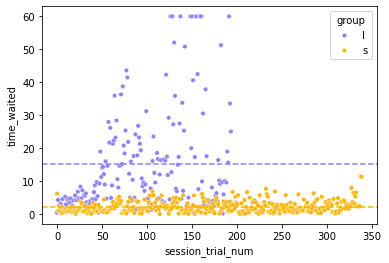

In [18]:
sns.scatterplot(x="session_trial_num",
                y="time_waited",
                hue="group",
                data=trials_examples,
                palette=custom_palette,
                s=20)
plt.axhline(y=trials_examples.loc[trials_examples.group == 's']['time_waited'].mean(), 
               color=custom_palette['s'], linestyle='--')
plt.axhline(y=trials_examples.loc[trials_examples.group == 'l']['time_waited'].mean(), 
               color=custom_palette['l'], linestyle='--')
plt.savefig(f'{figure_folder}/example_sessions_scatter.png')

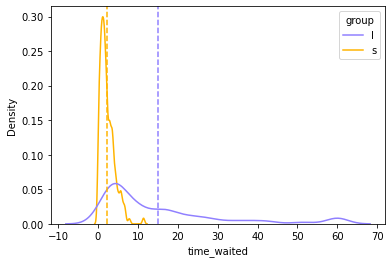

In [19]:
sns.kdeplot(data=trials_examples.reset_index(drop=True), 
                    x="time_waited", 
                    hue="group",
                    common_norm=False,
                    bw_adjust=0.5, 
                    palette=custom_palette)
plt.axvline(x=trials_examples.loc[trials_examples.group == 's']['time_waited'].mean(), 
               color=custom_palette['s'], linestyle='--')
plt.axvline(x=trials_examples.loc[trials_examples.group == 'l']['time_waited'].mean(), 
               color=custom_palette['l'], linestyle='--')
plt.savefig(f'{figure_folder}/example_sessions_kde.png')

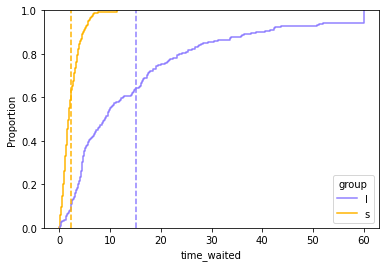

In [20]:
sns.ecdfplot(data=trials_examples.reset_index(drop=True), 
                    x="time_waited", 
                    hue="group",
                    palette=custom_palette)
plt.axvline(x=trials_examples.loc[trials_examples.group == 's']['time_waited'].mean(), 
               color=custom_palette['s'], linestyle='--')
plt.axvline(x=trials_examples.loc[trials_examples.group == 'l']['time_waited'].mean(), 
               color=custom_palette['l'], linestyle='--')
plt.savefig(f'{figure_folder}/example_sessions_ecdf.png')

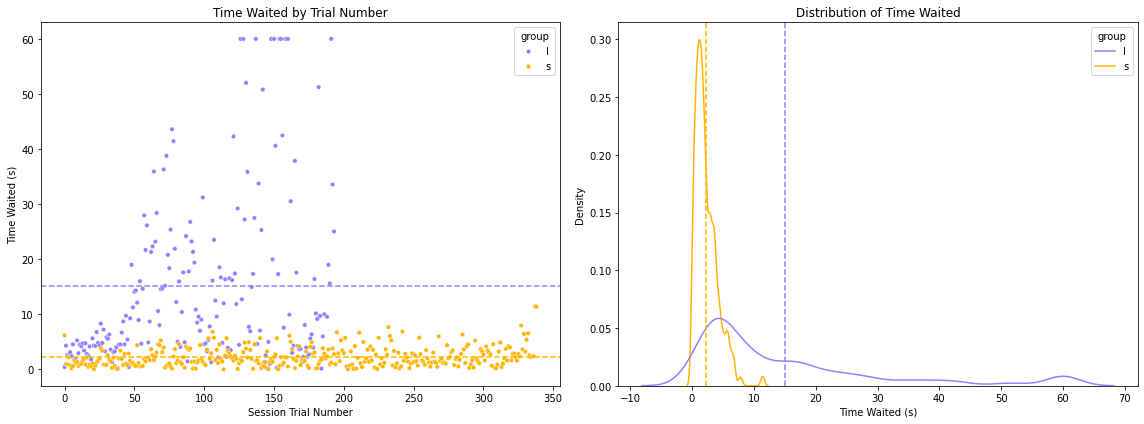

In [21]:
# Create side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left subplot: Scatter plot
sns.scatterplot(x="session_trial_num",
                y="time_waited",
                hue="group",
                data=trials_examples,
                palette=custom_palette,
                s=20,
                ax=ax1)
ax1.axhline(y=trials_examples.loc[trials_examples.group == 's']['time_waited'].mean(), 
           color=custom_palette['s'], linestyle='--')
ax1.axhline(y=trials_examples.loc[trials_examples.group == 'l']['time_waited'].mean(), 
           color=custom_palette['l'], linestyle='--')
ax1.set_title('Time Waited by Trial Number')
ax1.set_xlabel('Session Trial Number')
ax1.set_ylabel('Time Waited (s)')

# Right subplot: KDE plot
sns.kdeplot(data=trials_examples.reset_index(drop=True), 
            x="time_waited", 
            hue="group",
            common_norm=False,
            bw_adjust=0.5, 
            palette=custom_palette,
            ax=ax2)
ax2.axvline(x=trials_examples.loc[trials_examples.group == 's']['time_waited'].mean(), 
           color=custom_palette['s'], linestyle='--')
ax2.axvline(x=trials_examples.loc[trials_examples.group == 'l']['time_waited'].mean(), 
           color=custom_palette['l'], linestyle='--')
ax2.set_title('Distribution of Time Waited')
ax2.set_xlabel('Time Waited (s)')
ax2.set_ylabel('Density')

plt.tight_layout()
plt.savefig(f'{figure_folder}/example_sessions_combined.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
sessions_training.loc[sessions_training.session == 36]

In [ ]:
long_info = sessions_training.loc[sessions_training.dir=="2024-08-13_14-19-06_RZ054"].iloc[0]
trials_long = utils_c5v2.load_data(utils_c5v2.generate_trials_analyzed_path(data_folder, long_info))

short_info = sessions_training.loc[sessions_training.dir=="2024-08-13_10-45-33_RZ047"].iloc[0]
trials_short = utils_c5v2.load_data(utils_c5v2.generate_trials_analyzed_path(data_folder, short_info))

trials_examples = pd.concat([trials_long, trials_short])

In [ ]:
sns.scatterplot(x="session_trial_num",
                y="time_waited",
                hue="group",
                data=trials_examples,
                palette=custom_palette,
                s=20)
plt.axhline(y=trials_examples.loc[trials_examples.group == 's']['time_waited'].mean(), 
               color=custom_palette['s'], linestyle='--')
plt.axhline(y=trials_examples.loc[trials_examples.group == 'l']['time_waited'].mean(), 
               color=custom_palette['l'], linestyle='--')
plt.savefig(f'{figure_folder}/example_sessions_scatter_2.png')

In [ ]:
sns.kdeplot(data=trials_examples.reset_index(drop=True), 
                    x="time_waited", 
                    hue="group",
                    common_norm=False,
                    bw_adjust=0.5, 
                    palette=custom_palette)
plt.axvline(x=trials_examples.loc[trials_examples.group == 's']['time_waited'].mean(), 
               color=custom_palette['s'], linestyle='--')
plt.axvline(x=trials_examples.loc[trials_examples.group == 'l']['time_waited'].mean(), 
               color=custom_palette['l'], linestyle='--')
plt.savefig(f'{figure_folder}/example_sessions_kde_2.png')

In [ ]:
sns.ecdfplot(data=trials_examples.reset_index(drop=True), 
                    x="time_waited", 
                    hue="group",
                    palette=custom_palette)
plt.axvline(x=trials_examples.loc[trials_examples.group == 's']['time_waited'].mean(), 
               color=custom_palette['s'], linestyle='--')
plt.axvline(x=trials_examples.loc[trials_examples.group == 'l']['time_waited'].mean(), 
               color=custom_palette['l'], linestyle='--')
plt.savefig(f'{figure_folder}/example_sessions_ecdf_2.png')

## plots to be figured out

In [ ]:
for group, mice in cohort_group.items():
    fig, axs = plt.subplots(5, 1, figsize=(10, 10), sharex=True)
    for i, mouse in enumerate(mice):
        session_mouse = wait_df.loc[(wait_df.mouse == mouse) & (wait_df.group == group)]
        ax = axs.flat[i]
        ax.errorbar(session_mouse.session, session_mouse.tw_mean, session_mouse.tw_stdev, 
                    linestyle='None', marker='o', color=custom_palette[group], label='mean')
        ax.scatter(session_mouse.session, session_mouse.tw_median, label='median', color='yellowgreen')
        ax.set_title(mouse)
        ax.set_xlabel('Sessions')
        ax.set_ylabel('Time Waited (s)')
        ax.set_ylim([-5, 35])
    
    if group == "s":
        axs.flat[3].axis('off')
        axs.flat[4].axis('off')
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.12, 1))
    plt.tight_layout()
    plt.savefig(f'{figure_folder}/tw_plots_{group}.png', bbox_inches='tight', dpi=300)

In [ ]:
for group, mice in cohort_group.items():
    fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True, sharey=True)
    for i, mouse in enumerate(mice):
        session_mouse = wait_df.loc[(wait_df.mouse == mouse) & (wait_df.group == group)]
        ax = axs.flat[i]
        ax.errorbar(session_mouse.session, session_mouse.tw_mean_g, session_mouse.tw_stdev_g, 
                    linestyle='None', marker='o', color=custom_palette[group], label='mean')
        ax.scatter(session_mouse.session, session_mouse.tw_median_g, label='median', color='yellowgreen')
        ax.set_title(mouse)
        ax.set_xlabel('Sessions')
        ax.set_ylabel('Time Waited (s)')
        ax.set_ylim([-5, 35])
    
    if group == "s":
        axs.flat[2].axis('off')
        # axs.set_ylim(0, 35)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.12, 1))
    plt.tight_layout()
    plt.savefig(f'{figure_folder}/tw_good_plots_{group}.png', bbox_inches='tight', dpi=300)

In [ ]:
def calculate_subplot_row_col(session_mouse, plots_per_row):
    days_trained = len(session_mouse)
    num_rows = (days_trained - 1) // plots_per_row + 1
    num_cols = min(days_trained, plots_per_row)
    return num_rows, num_cols

In [ ]:
for mouse in mouse_list:
    session_mouse = sessions_training.loc[sessions_training.mouse == mouse]
    num_rows, num_cols = calculate_subplot_row_col(session_mouse, 8)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(21.5, 2.5 * num_rows))

    for i, (_, session_info) in enumerate(session_mouse.iterrows()):
        all_trials = utils_c5.load_data(utils_c5.generate_trials_analyzed_path(data_folder, session_info))
        row_idx = i // num_cols
        col_idx = i % num_cols
        ax = axs[row_idx, col_idx]
        
        sns.scatterplot(x="session_trial_num",
                        y="time_waited",
                        hue="group",
                        data=all_trials,
                        palette=custom_palette,
                        ax=axs.flat[i])
        ax.set_ylim([0,35])
        ax.set_title(f'Session {i}')
        ax.legend().remove()
    
    # Remove any unused subplots
    if i + 1 < num_rows * num_cols:
        for j in range(i + 1, num_rows * num_cols):
            axs.flat[j].axis('off')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Save the figure with proper spacing around the subplots
    plt.savefig(f'{figure_folder}/trial_num_vs_tw_{mouse}.png', bbox_inches='tight', dpi=300)
    plt.close()